### Observing alpha 
 
 In this notebook I will attempt to efficiently calculate and observe the optimal step size  during a training loop derived as: 
 
$\alpha^*=\frac{-d^{\top} g}{d^{\top} H d}$
 

In [1]:
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector
from torch.nn.utils import vector_to_parameters  # this is NOT inverse of params_to_vector, see cell below
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from warnings import warn
import matplotlib.pyplot as plt
from backpack import backpack, extend
from backpack.extensions import (
    GGNMP,
    HMP,
    KFAC,
    KFLR,
    KFRA,
    PCHMP,
    BatchDiagGGNExact,
    BatchDiagGGNMC,
    BatchDiagHessian,
    BatchGrad,
    BatchL2Grad,
    DiagGGNExact,
    DiagGGNMC,
    DiagHessian,
    SqrtGGNExact,
    SqrtGGNMC,
    SumGradSquared,
    Variance,
)

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


In [2]:
def vector_to_parameter_list(vec, parameters):
    """Convert the vector `vec` to a parameter-list format matching
    `parameters`. This function is the inverse of `parameters_to_vector` from
    `torch.nn.utils`. In contrast to `vector_to_parameters`, which replaces the
    value of the parameters, this function leaves the parameters unchanged and
    returns a list of parameter views of the vector.

    Args:
        vec (torch.Tensor): The vector representing the parameters. This vector
            is converted to a parameter-list format matching `parameters`.
        parameters (iterable): An iterable of `torch.Tensor`s containing the
            parameters. These parameters are not changed by the function.

    Raises:
        Warning if not all entries of `vec` are converted.
    """

    if not isinstance(vec, torch.Tensor):
        raise TypeError(f"`vec` should be a torch.Tensor, not {type(vec)}.")

    # Put slices of `vec` into `params_list`
    params_list = []
    pointer = 0
    for param in parameters:
        num_param = param.numel()
        params_list.append(
            vec[pointer: pointer + num_param].view_as(param).data
        )
        pointer += num_param

    # Make sure all entries of the vector have been used (i.e. that `vec` and
    # `parameters` have the same number of elements)
    if pointer != len(vec):
        warn("Not all entries of `vec` have been used.")

    return params_list

In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),  # Input size is 784 (28x28), hidden layer size is 128
            nn.ReLU(),
            nn.Linear(128, 64),   # Second hidden layer size is 64
            nn.ReLU(),
            nn.Linear(64, 10)     # Output layer for 10 classes
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model
model = SimpleNet()
model = extend(model, use_converter=True) # Extend the loss function

In [4]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    alpha_values = []  # store the alpha values
    alpha_values_unnormed = []
    percentages = []
    loss_values = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # save current parameters
        theta_0 = parameters_to_vector(model.parameters())
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimization
        with backpack(
        GGNMP(),
            ):
            loss.backward()
            
        # Extract gradients and convert to a vector
        gradients = parameters_to_vector(param.grad for param in model.parameters() if param.grad is not None)
        
        gradients_normalized = gradients / torch.norm(gradients)
        
        optimizer.step()
        
        
        d_unnormalized = parameters_to_vector(model.parameters()) - theta_0 # direction of adjustment
        
        d_normalized = d_unnormalized / torch.norm(d_unnormalized)          # normalized direction of adjustment
    
        d = vector_to_parameter_list(d_normalized, model.parameters())      # in shape of params (expected by ggnmp)
        
        ggnmp = [p.ggnmp for p in model.parameters()]        # extract ggnmp functions (per each bias and weights)
        
        H_times_d = []  # result list
        
        
        for d,ggnmp in zip(d, ggnmp):
            H_times_d.append(ggnmp(d))    # holds the result of H*d for each parameter (6 in this network)
        
        H_times_d_vec = parameters_to_vector(H_times_d)
        
        denom = torch.dot(H_times_d_vec, d_normalized) # denominator: d^T*(H*d) using d_normed
        
        denom_unnormed = torch.dot(H_times_d_vec, d_unnormalized) # using d_unnormed
        
        numerator = - torch.dot(gradients, d_normalized)  # numerator: - d^T*g 
        
        numerator_unnormed = - torch.dot(gradients, d_unnormalized)
        
        
        alpha = numerator / denom
        
        alpha_unnormed = numerator_unnormed / denom_unnormed
         
        alpha_values.append(alpha)
        
        alpha_values_unnormed.append(alpha_unnormed)
        
        loss_values.append(loss.item())
        
        position = 0 # only for printing, I print different positions of the data each time
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            percentages.append(batch_idx / len(train_loader))
                               
            # print("Current parameter vector length:", len(theta_0), ", values:", theta_0[position:position + 5])  # observe a different position each time
            # print("d vector unnormalized length:", len(d_unnormalized), "norm:", torch.norm(d_unnormalized), "\n values:", d_unnormalized[position:position + 5])
            # print("d vector normalized length:", len(d_normalized), ", norm:", torch.norm(d_normalized), "\n values:", d_normalized[position:position + 5])
            # print("gradients vector length:", len(gradients), "\n values:", gradients[position:position + 5])
            # print("H*d length:", len(H_times_d), "\n values: ", H_times_d[position])
            # print("H*d vector shape:", H_times_d_vec.shape)
            # print("denominator:", denom, "numerator:", numerator)
            # print("alpha with d normalized: ", alpha, ", alpha with d unnormalized:", alpha_unnormed)                  
                               
        total_params = sum(p.numel() for p in model.parameters()) # only for printing
        position = (position + 5) % total_params
                          
    # Convert alpha values to a tensor
    alpha_values_tensor = torch.tensor(alpha_values)
    alpha_unnormed_tensor = torch.tensor(alpha_values_unnormed)
    loss_tensor = torch.tensor(loss_values)
    
    # Split alpha values into chunks of size 10
    alpha_chunks = alpha_values_tensor.chunk(len(alpha_values_tensor) // 10)
    alpha_unnormed_chunks = alpha_unnormed_tensor.chunk(len(alpha_values_unnormed) // 10)
    loss_chunks = loss_tensor.chunk(len(loss_tensor) // 10)

    # Calculate average alpha values for each chunk
    avg_alpha_values = [chunk.mean() for chunk in alpha_chunks]
    avg_alpha_unnormed_values = [chunk.mean() for chunk in alpha_unnormed_chunks]
    avg_loss_values = [chunk.mean() for chunk in loss_chunks]
    
    # Assign calculated averages to variables
    avg_alpha_values_tensor = torch.tensor(avg_alpha_values)
    avg_alpha_unnormed_values_tensor = torch.tensor(avg_alpha_unnormed_values)
    avg_loss_values_tensor = torch.tensor(avg_loss_values)
    
    print(loss_values[:5])
    # plot loss
    plt.plot(loss_tensor.detach().numpy())
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title(f"Loss Over Epoch {epoch}")
    plt.show()
    
    # Plot alpha values
    plt.plot(alpha_values_tensor.detach().numpy())
    # Add vertical lines for each percentage
    plt.xlabel("Batch")
    plt.ylabel("Alpha Value")
    plt.title(f"Alpha Values Over Epoch {epoch}")
    plt.show()
    
    """
    # Plot alpha values using unnormed version
    plt.plot(alpha_unnormed_tensor.detach().numpy())
    for percent in percentages:
        plt.axvline(x=percent * len(alpha_unnormed_tensor), color='r', linestyle='--', linewidth=0.4)
    plt.xlabel("Iteration")
    plt.ylabel("Alpha Value")
    plt.title("Alpha with unnormed d Values Over Training")
    plt.show()
    """
    
    # plot smoothened loss
    plt.plot(avg_loss_values_tensor.detach().numpy())
    plt.xlabel("Chunk")
    plt.ylabel("Average Loss (each 10 batches)")
    plt.title(f"Smoothened Loss Over Epoch {epoch}")
    plt.show()
    
    # Plot average alpha values
    plt.plot(avg_alpha_values_tensor.detach().numpy())
    plt.xlabel("Chunk")
    plt.ylabel("Average Alpha Value (each 10 batches)")
    plt.title(f"Smoothened Alpha Values Over Epoch {epoch}")
    plt.show()
    
    """
    # Plot average alpha values using unnormed version
    plt.plot(avg_alpha_unnormed_values_tensor.detach().numpy())
    for percent in percentages:
        plt.axvline(x=percent * len(avg_alpha_unnormed_values_tensor), color='r', linestyle='--', linewidth=0.3)
    plt.xlabel("Iteration")
    plt.ylabel("Average Alpha Value (each 10 batches)")
    plt.title("Average Alpha with unnormed d Values Over Training")
    plt.show()
    """
    
        
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')


In [9]:
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device
model.to(device)

# Set up optimizer and loss function
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
criterion = extend(criterion) # for backpack

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332535
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.221039
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.176410
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.293089
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.167724
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.216652
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.108624
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.185710
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.200424
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.173869
[2.3325347900390625, 2.2464439868927, 2.204449415206909, 2.179441213607788, 2.044635772705078]


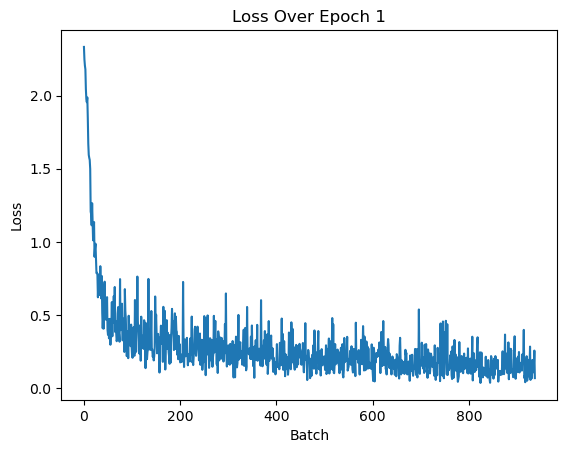

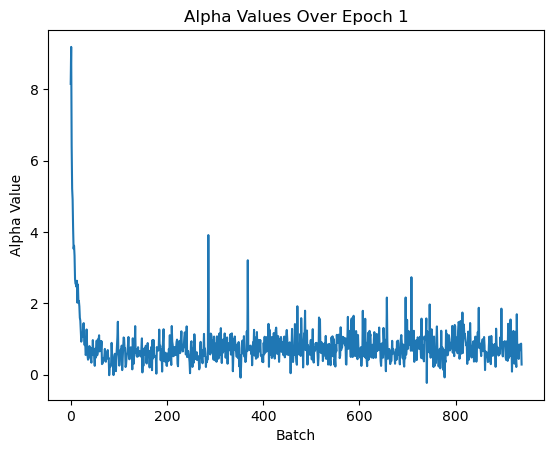

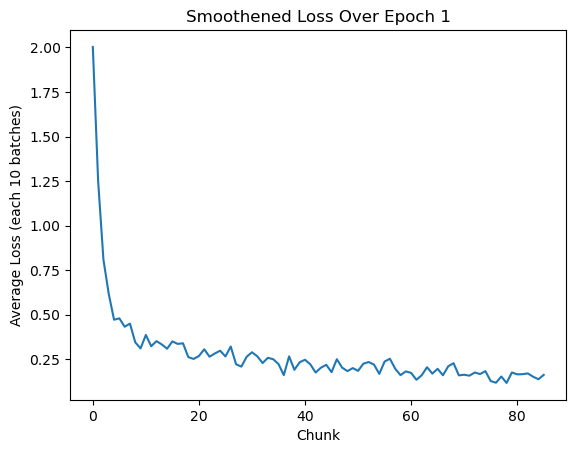

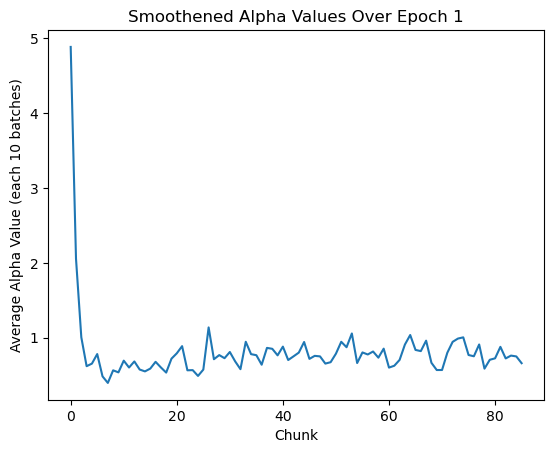


Test set: Average loss: 0.0001, Accuracy: 9562/10000 (95.62%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.063373
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.187798
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.095974
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.321517
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.043698
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.086987
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.056737
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.060449
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.056590
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.141818
[0.06337268650531769, 0.21685689687728882, 0.10122331976890564, 0.23326216638088226, 0.13223649561405182]


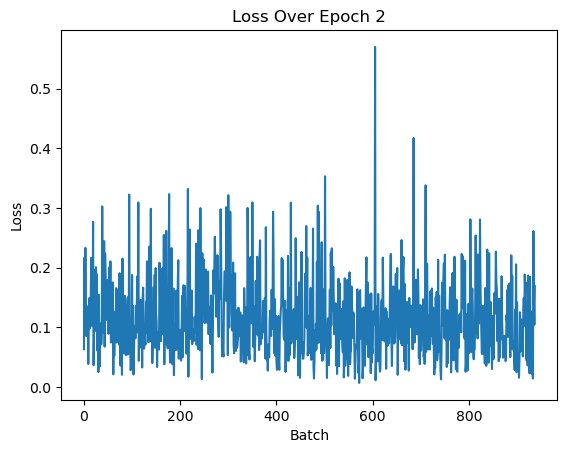

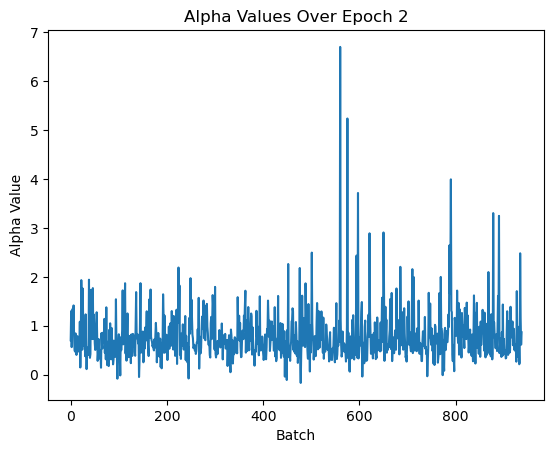

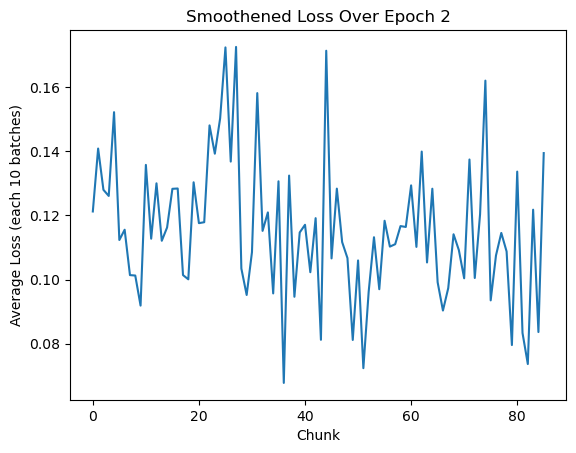

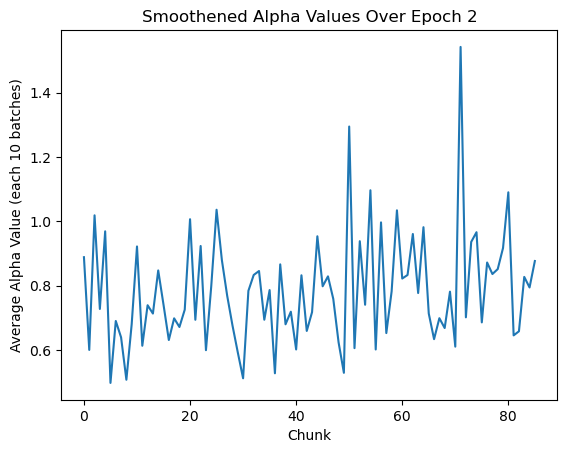


Test set: Average loss: 0.0001, Accuracy: 9709/10000 (97.09%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.031971
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.134509
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.056932
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.066610
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.017137
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.042469
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.055606
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.009125
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.038865
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.069570
[0.03197070211172104, 0.025576457381248474, 0.11449061334133148, 0.14028142392635345, 0.06580228358507156]


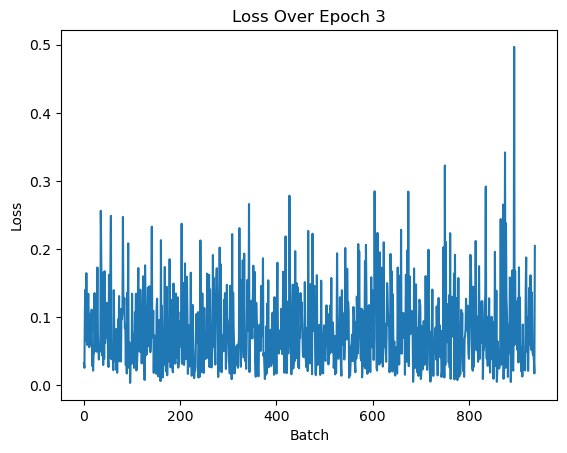

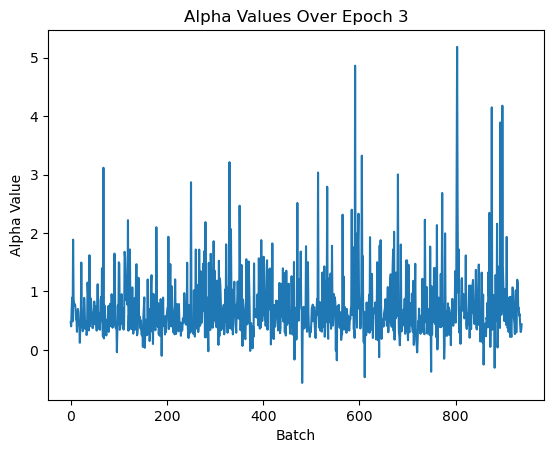

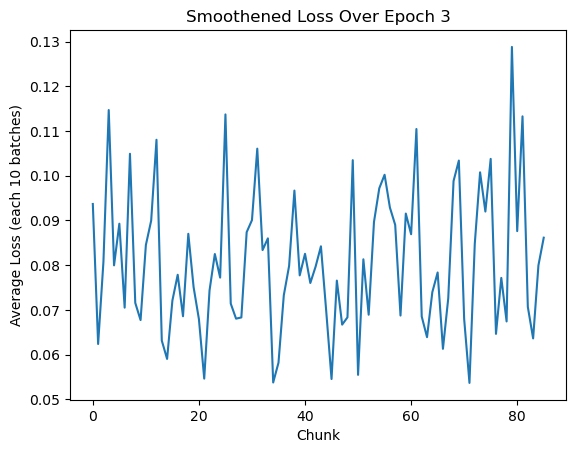

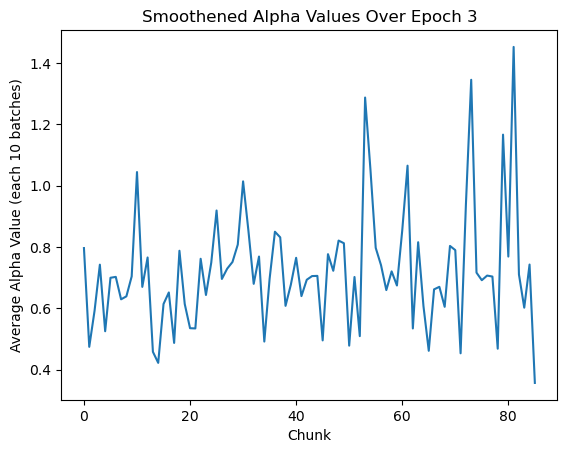


Test set: Average loss: 0.0001, Accuracy: 9750/10000 (97.50%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.026846
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.044393
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.142446
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.087995
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.007954
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.108505
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.140800
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.155114
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.005667
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.022882
[0.02684640884399414, 0.015869583934545517, 0.05580953136086464, 0.04041960835456848, 0.04953122138977051]


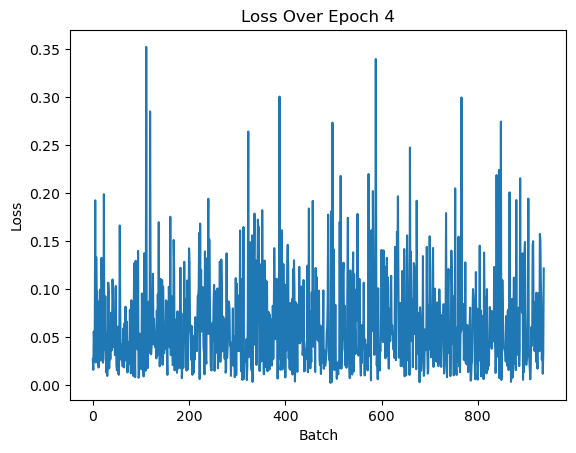

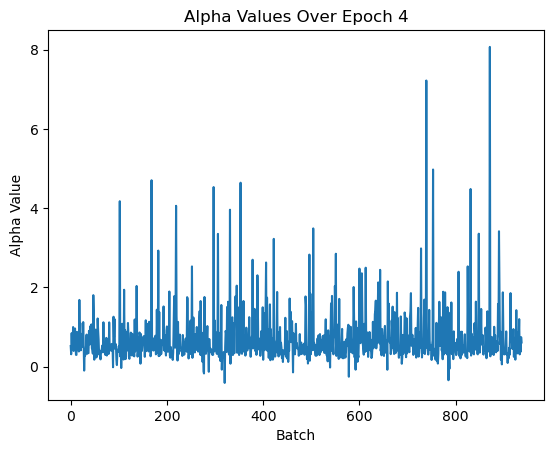

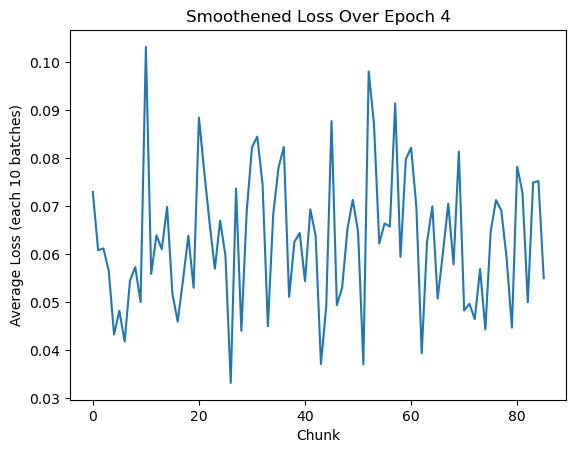

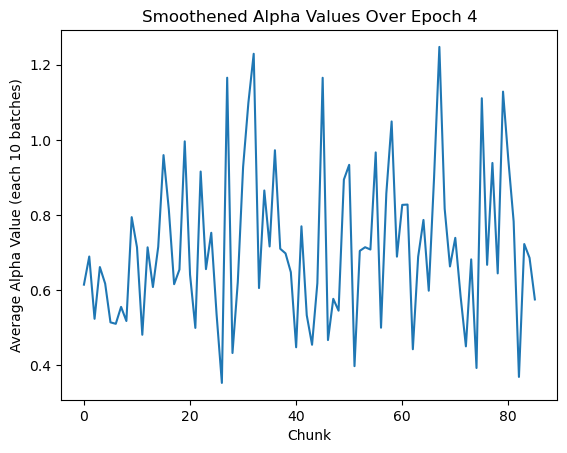


Test set: Average loss: 0.0001, Accuracy: 9719/10000 (97.19%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.032342
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.022786
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.071142
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.016964
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.059148
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.013913
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.022049
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.047200
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.007119
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.084377
[0.032341983169317245, 0.014666402712464333, 0.09006956964731216, 0.0031990371644496918, 0.013410227373242378]


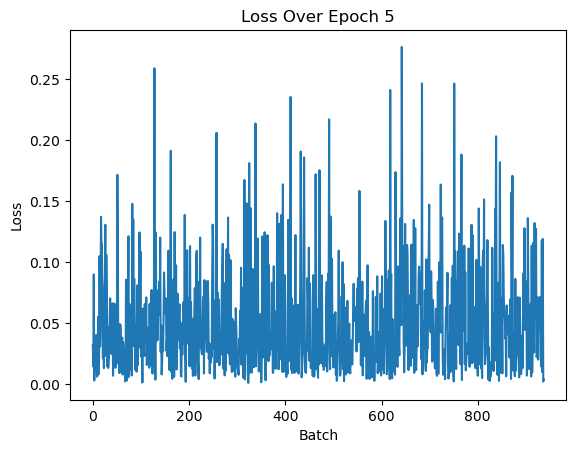

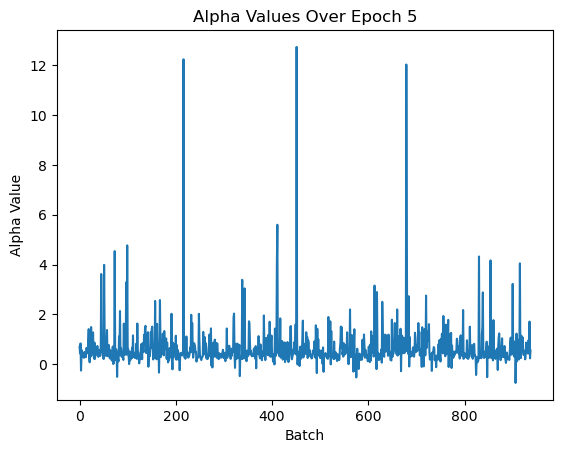

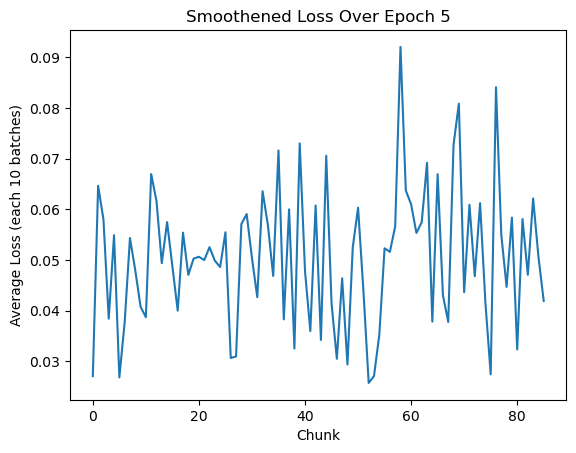

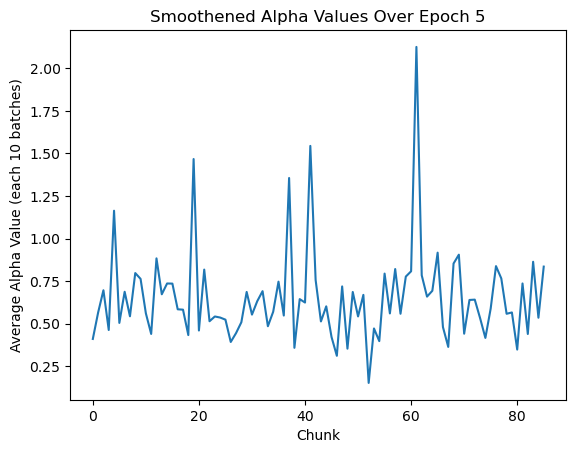


Test set: Average loss: 0.0001, Accuracy: 9764/10000 (97.64%)



In [11]:
# Number of epochs
num_epochs = 5

# Training and testing loop
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    test(model, device, test_loader, criterion)
